In [1]:
!pip install pyomo
!wget https://people.montefiore.uliege.be/cornelusse/utils/ampl.linux-intel64.zip
!unzip /content/ampl.linux-intel64.zip
!chmod +x /content/ampl.linux-intel64/ipopt # To make sure it can be executed
!chmod +x /content/ampl.linux-intel64/cbc # To make sure it can be executed

--2025-08-12 15:25:15--  https://people.montefiore.uliege.be/cornelusse/utils/ampl.linux-intel64.zip
Resolving people.montefiore.uliege.be (people.montefiore.uliege.be)... 139.165.57.148
Connecting to people.montefiore.uliege.be (people.montefiore.uliege.be)|139.165.57.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17486900 (17M) [application/zip]
Saving to: ‘ampl.linux-intel64.zip.1’

ampl.linux-intel64. 100%[===================>]  16.68M  14.8MB/s    in 1.1s    

2025-08-12 15:25:17 (14.8 MB/s) - ‘ampl.linux-intel64.zip.1’ saved [17486900/17486900]

Archive:  /content/ampl.linux-intel64.zip
replace __MACOSX/._ampl.linux-intel64? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!pip install pandapower --upgrade

In [3]:
!pip install networkx

In [4]:
!pip install gurobipy  # install gurobipy, if not already installed

In [113]:
import gurobipy as gp
import time
import pandas as pd
import xarray as xr
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import pyomo.environ as pyo
import math
import pandapower as pp


# Create a new graph
G = nx.DiGraph()

In [114]:
def create_network():

    import pandapower as pp

# Crée le réseau
    net = pp.create_empty_network()

# Bases
    Pbase = 100  # MVA
    Vbase_high = 110  # kV
    Vbase_medium = 20  # kV
    Vbase_low = 0.4  # kV

# Buses
    b0 = pp.create_bus(net, vn_kv=Vbase_high, name="Bus grid", geodata=(0,10))
    b1 = pp.create_bus(net, vn_kv=Vbase_high, name="DSO 1", geodata=(5,12))
    b2 = pp.create_bus(net, vn_kv=Vbase_high, name="DSO 2", geodata=(5,8))
    b3 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus MV_1", geodata=(10,12))
    b4 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus MV_2", geodata=(10,8))
    b5 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus LV_1", geodata=(15,12))
    b6 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus LV_2", geodata=(15,8))
    b7 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus éolien", geodata=(10,14))
    b8 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus industriel", geodata=(10,10))
    b9 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus load", geodata=(15,14))
    b10 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus PV", geodata=(15,10))
    b11 = pp.create_bus(net, vn_kv=Vbase_high, name="TSO 1", geodata=(2,12))
    b12 = pp.create_bus(net, vn_kv=Vbase_high, name="TSO 2", geodata=(2,8))

# Lignes
    pp.create_line(net, b0, b1, length_km=12, std_type='149-AL1/24-ST1A 110.0', name="line1")
    pp.create_line(net, b1, b2, length_km=10, std_type='149-AL1/24-ST1A 110.0', name="line2")
    pp.create_line(net, b0, b2, length_km=10, std_type='149-AL1/24-ST1A 110.0', name="line3")
    pp.create_line(net, b3, b7, length_km=0.23, std_type='NA2XS2Y 1x185 RM/25 12/20 kV', name="line4")
    pp.create_line(net, b4, b8, length_km=0.3, std_type='NA2XS2Y 1x185 RM/25 12/20 kV', name="line5")
    pp.create_line(net, b5, b9, length_km=3, std_type='94-AL1/15-ST1A 0.4', name="line6")
    pp.create_line(net, b6, b10, length_km=0.45, std_type='94-AL1/15-ST1A 0.4', name="line7")
    pp.create_line(net, b0, b11, length_km=16, std_type='149-AL1/24-ST1A 110.0', name= 'line8')
    pp.create_line(net, b11, b1, length_km=24, std_type='149-AL1/24-ST1A 110.0', name= 'line9')
    pp.create_line(net, b0, b12, length_km=22, std_type='149-AL1/24-ST1A 110.0', name= 'line10')
    pp.create_line(net, b12, b2, length_km=16, std_type='149-AL1/24-ST1A 110.0', name= 'line11')

# Transformateurs
    pp.create_transformer(net, b1, b3, std_type="25 MVA 110/20 kV", name="TR_1")
    pp.create_transformer(net, b2, b4, std_type="25 MVA 110/20 kV", name="TR_2")
    pp.create_transformer(net, b3, b5, std_type="0.4 MVA 20/0.4 kV", name="TR_3")
    pp.create_transformer(net, b4, b6, std_type="0.4 MVA 20/0.4 kV", name="TR_4")

# Éléments de bus
    pp.create_ext_grid(net, bus=b0, vm_pu=1.00, name="Grid Connection")
    pp.create_load(net, bus=b9, p_mw=0.02, q_mvar=0.02, name="Residential Load")
    pp.create_gen(net, bus=b10, p_mw=0.2, vm_pu=1.00, name="PV", max_q_mvar=200, min_q_mvar=0, max_p_mw=300, min_p_mw=0, controllable=False)
    pp.create_gen(net, bus=b7, p_mw=6.5, vm_pu=1.0, name="Wind Turbine", controllable=False)
    pp.create_load(net, bus=b8, p_mw=6, q_mvar=1.8, name="Industry")
    pp.create_load(net, bus=b11, p_mw=20, q_mvar=9, name="Datacenter")
    pp.create_load(net, bus=b12, p_mw=50, q_mvar=24, name="Big industry")

# Donner accès à net
    return net

In [115]:
def create_digraph():
  net = create_network()

  import json
  import networkx as nx
  import matplotlib.pyplot as plt
# 1. Conversion du réseau Pandapower en DiGraph
# ================================
  G = nx.DiGraph()

# Créer les positions à partir de la colonne "geo"
  pos = {}
  for idx, row in net.bus.iterrows():
  # Extraire le champ 'geo' qui est une chaîne de caractères représentant un dictionnaire JSON
      geo_data = row['geo']

  # Convertir la chaîne JSON en un dictionnaire Python
      geo_dict = json.loads(geo_data)

  # Extraire la liste des coordonnées
      coordinates = geo_dict["coordinates"]

  # Ajouter les coordonnées dans le dictionnaire pos
      pos[idx] = tuple(coordinates)  # Assigner les coordonnées sous forme de tuple

# Ajouter les nœuds (avec le nom comme label) and voltage
  for idx, row in net.bus.iterrows():
      G.add_node(idx, label=row["name"], pos=pos[idx], vn_kv=row["vn_kv"])


# Ajouter les arêtes pour les lines
  for _, row in net.line.iterrows():
      G.add_edge(row["from_bus"], row["to_bus"], type="line", name=row["name"], length=row["length_km"], std_type=row["std_type"])

# Ajouter les arêtes pour les transformateurs
  for _, row in net.trafo.iterrows():
      G.add_edge(row["hv_bus"], row["lv_bus"], type="trafo", name=row["name"], std_type = None)

# Ajouter les générateurs et les charges comme attributs aux nœuds
  for _, row in net.gen.iterrows():
      G.nodes[row["bus"]]["type"] = "gen"
      G.nodes[row["bus"]]["gen_name"] = row["name"]
      G.nodes[row["bus"]]["gen_power"] = row["p_mw"]

  for _, row in net.load.iterrows():
      G.nodes[row["bus"]]["type"] = "load"
      G.nodes[row["bus"]]["load_name"] = row["name"]
      G.nodes[row["bus"]]["load_power"] = row["p_mw"]

  for _, row in net.ext_grid.iterrows():
      G.nodes[row["bus"]]["type"] = "ext_grid"
      G.nodes[row["bus"]]["grid_name"] = row["name"]

# 2. Ajout des puissances consommées et injectées aux nœuds
# ================================
  nx.set_node_attributes(G, 0.0, "P_load")
  nx.set_node_attributes(G, 0.0, "P_gen")

# Charges
  for _, row in net.load.iterrows():
      G.nodes[row["bus"]]["P_load"] += row["p_mw"]
      print(row)

# Générateurs
  for _, row in net.gen.iterrows():
      G.nodes[row["bus"]]["P_gen"] += row["p_mw"]

# Source externe
  for _, row in net.ext_grid.iterrows():
      G.nodes[row["bus"]]["P_gen"] += 0

# Calculate P_net
  for n in G.nodes:
      G.nodes[n]["P_net"] = G.nodes[n]["P_gen"] - G.nodes[n]["P_load"]

# Create subnetworks (NetworkX DiGraphs) from the main graph G
  network1_buses = [0, 1, 2, 11,12]
  network2_buses = [3, 7, 5, 9, 10]
  network3_buses = [4, 8, 6]

# Assign G1 to G and then add power attributes to nodes in G
  #G = G.subgraph(network1_buses)

  for n in G.nodes:
      G.nodes[n]["P"] = G.nodes[n]["P_net"] # Assign P_net to 'P' attribute

# 3. Préparer les couleurs des nœuds en fonction de P_net
# ================================
  node_colors = []
  for n, data in G.nodes(data=True):
      if data["P_net"] > 0:
          node_colors.append("green")   # producteur
      elif data["P_net"] < 0:
          node_colors.append("red")     # consommateur
      else:
          node_colors.append("gray")    # neutre

# 4. Préparer les labels : Nom + P_net
# ================================
  labels = {n: f"{data['label']}\nP={round(data['P_net'],2)}MW"
            for n, data in G.nodes(data=True)}

# 5. Function to plot the network
# ================================
  def plot_network():
      pos = nx.get_node_attributes(G, 'pos')

      plt.figure(figsize=(12, 8))
      nx.draw(
          G, pos,
          with_labels=True, labels=labels,
          node_size=1200, node_color=node_colors,
          edgecolors="black", font_size=8,
          alpha=0.85
          )

  # Labels des arêtes (type ligne ou trafo)
      edge_labels = nx.get_edge_attributes(G, 'type')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

      plt.title("Réseau électrique avec puissances (P_net)")
      plt.axis("equal")
      plt.show()


  return G, plot_network()

name               Residential Load
bus                               9
p_mw                           0.02
q_mvar                         0.02
const_z_percent                 0.0
const_i_percent                 0.0
sn_mva                          NaN
scaling                         1.0
in_service                     True
type                            wye
Name: 0, dtype: object
name               Industry
bus                       8
p_mw                    6.0
q_mvar                  1.8
const_z_percent         0.0
const_i_percent         0.0
sn_mva                  NaN
scaling                 1.0
in_service             True
type                    wye
Name: 1, dtype: object
name               Datacenter
bus                        11
p_mw                     20.0
q_mvar                    9.0
const_z_percent           0.0
const_i_percent           0.0
sn_mva                    NaN
scaling                   1.0
in_service               True
type                      wye
Name: 2, dtype

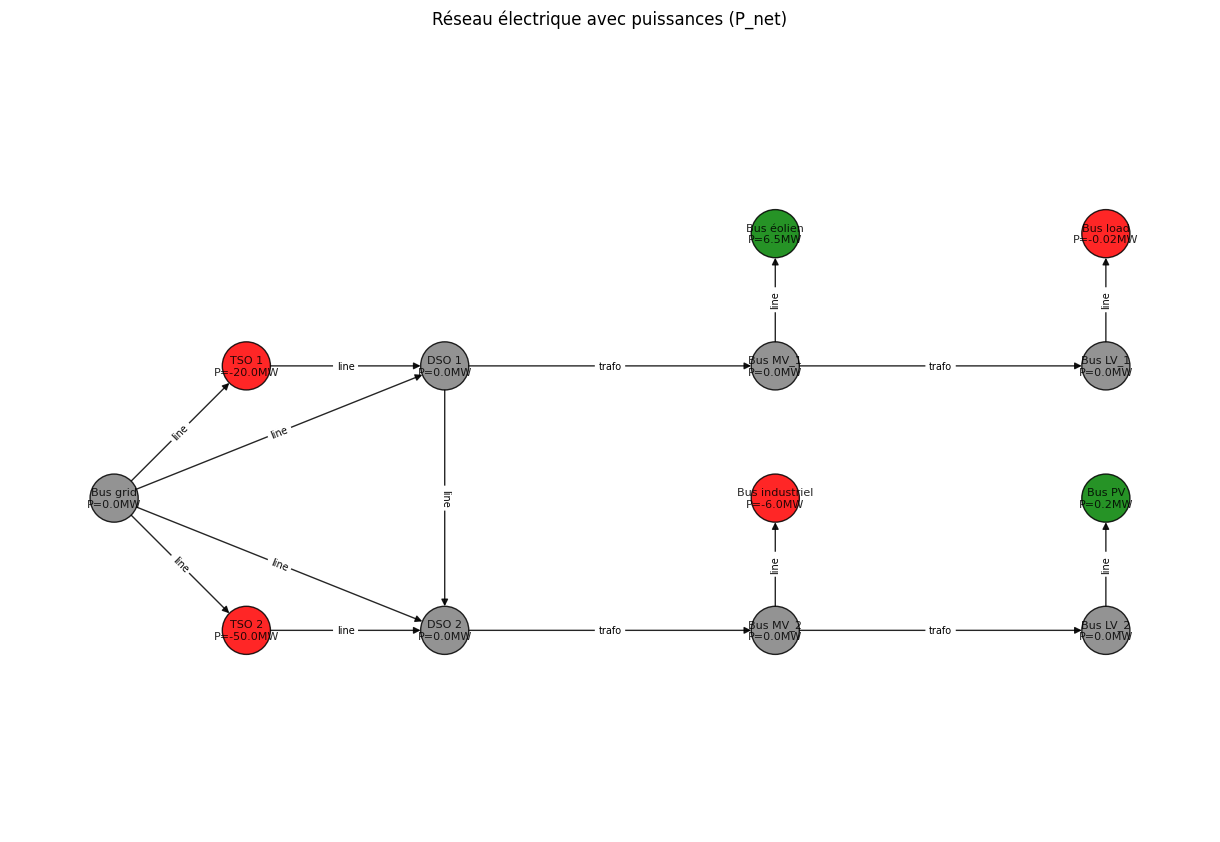

Value of G.nodes[11]['P'] after updating G: -20.0


In [116]:
G, plot_func = create_digraph()
print(f"Value of G.nodes[11]['P'] after updating G: {G.nodes[11]['P']}")

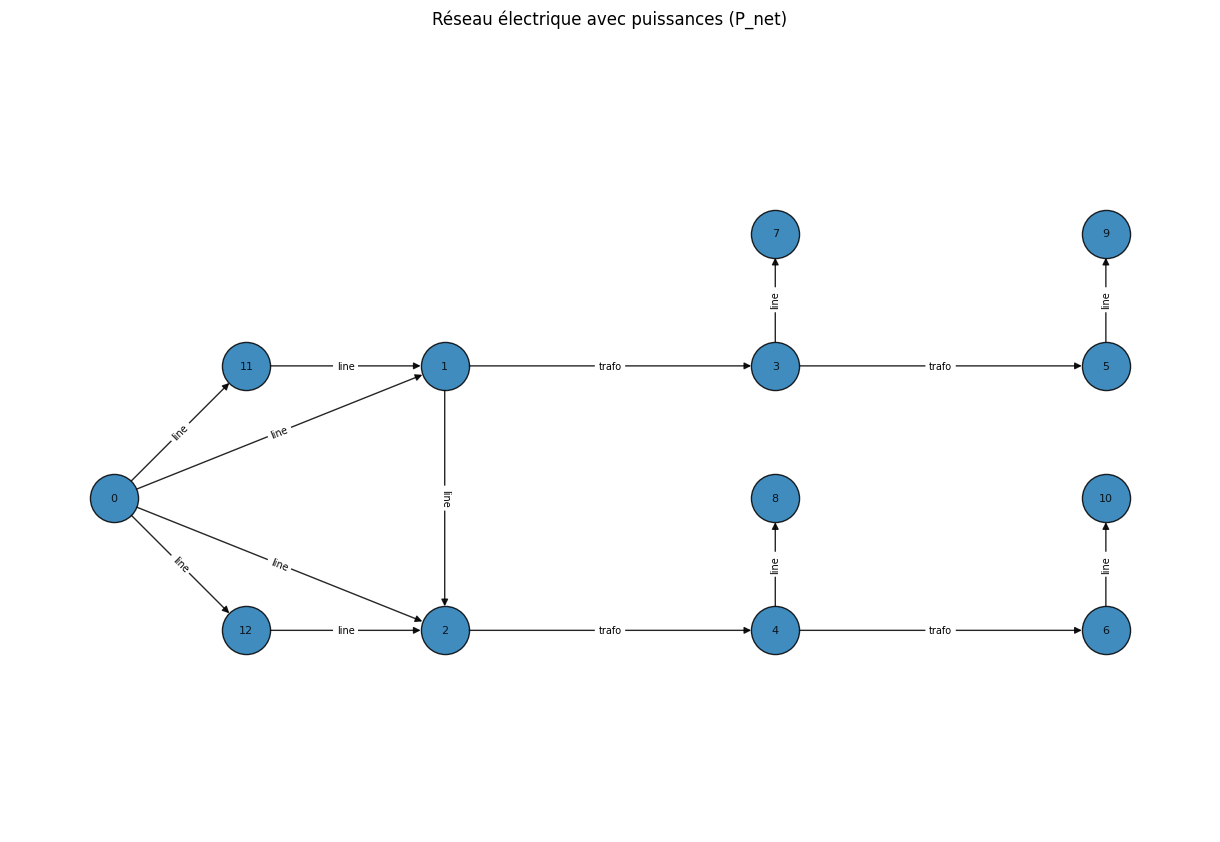

In [117]:
def plot_network(G):
      pos = nx.get_node_attributes(G, 'pos')

      plt.figure(figsize=(12, 8))
      nx.draw(
          G, pos,
          with_labels=True,
          node_size=1200,
          edgecolors="black", font_size=8,
          alpha=0.85
          )

  # Labels des arêtes (type ligne ou trafo)
      edge_labels = nx.get_edge_attributes(G, 'type')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

      plt.title("Réseau électrique avec puissances (P_net)")
      plt.axis("equal")
      plt.show()

plot_network(G)

In [118]:
# Define base values for the per-unit system
s_base = 100  # MVA


v_base_high = 110 # kV (From the create_network function)

# Calculate base current (I_base)
# S_base = V_base * I_base (for single phase, or sqrt(3)*V_base*I_base for three phase)
# Assuming three-phase system: I_base = S_base / (sqrt(3) * V_base)
i_base_high = s_base / (math.sqrt(3) * v_base_high) # kA

# Calculate base impedance (Z_base)
# Z_base = V_base^2 / S_base
z_base_high = v_base_high**2 / s_base # ohms

# Calculate base susceptance (B_base)
# B_base = 1 / Z_base = S_base / V_base^2
b_base_high = s_base / v_base_high**2 # Siemens

print(f"Base Power (S_base): {s_base} MVA")
print(f"Base Voltage (V_base_high): {v_base_high} kV")
print(f"Base Current (I_base_high): {i_base_high} kA")
print(f"Base Impedance (Z_base_high): {z_base_high} ohms")
print(f"Base Susceptance (B_base_high): {b_base_high} Siemens")

Base Power (S_base): 100 MVA
Base Voltage (V_base_high): 110 kV
Base Current (I_base_high): 0.524863881081478 kA
Base Impedance (Z_base_high): 121.0 ohms
Base Susceptance (B_base_high): 0.008264462809917356 Siemens


In [119]:
# Define the maximum current in kA
I_max_kA = 0.47

# Get the base current in kA from the previous calculation
# Assuming i_base_high is the relevant base current for the lines in the model
I_base_kA = i_base_high

# Calculate the upper bound for current in per-unit
I_max_pu = I_max_kA / I_base_kA

# The lower bound for current is the negative of the upper bound, assuming symmetrical limits
I_min_pu = -I_max_pu

print(f"Maximum Current (kA): {I_max_kA}")
print(f"Base Current (kA): {I_base_kA}")
print(f"Upper bound for current (per-unit): {I_max_pu}")
print(f"Lower bound for current (per-unit): {I_min_pu}")

# Update the Pyomo model's bounds if they are defined globally or need to be updated
# Assuming I_min and I_max are global variables used in the Pyomo model definition
I_min = I_min_pu
I_max = I_max_pu

print("\nUpdated global current bounds (per-unit):")
print(f"I_min: {I_min}")
print(f"I_max: {I_max}")

Maximum Current (kA): 0.47
Base Current (kA): 0.524863881081478
Upper bound for current (per-unit): 0.8954702675131095
Lower bound for current (per-unit): -0.8954702675131095

Updated global current bounds (per-unit):
I_min: -0.8954702675131095
I_max: 0.8954702675131095


In [120]:
def calculate_current_bounds(line_type, v_base):
    """
    Calculates the upper and lower bounds for current in per-unit
    based on the line type's maximum current capacity.

    Args:
        line_type (str): The type of the transmission line.
        i_base_kA (float): The base current in kA for the system.

    Returns:
        tuple: A tuple containing (I_min_pu, I_max_pu).
               Returns (None, None) if the line type is not found.
    """
    # Define a dictionary mapping line types to their maximum current capacity in kA
    # NOTE: This is a placeholder. You should populate this dictionary
    # with the actual maximum current capacities for your line types.
    i_base_kA = s_base / (math.sqrt(3) * v_base) # kA


    line_type_max_current_kA = {
        '149-AL1/24-ST1A 110.0': 0.47, # Example value for 110 kV lines
        'NA2XS2Y 1x185 RM/25 12/20 kV': 0.3, # Example value for 20 kV lines
        '94-AL1/15-ST1A 0.4': 0.15 # Example value for 0.4 kV lines
    }

    if line_type in line_type_max_current_kA:
        I_max_kA = line_type_max_current_kA[line_type]

        # Calculate the upper bound for current in per-unit
        I_max_pu = I_max_kA / i_base_kA

        # The lower bound for current is the negative of the upper bound
        I_min_pu = -I_max_pu

        return I_min_pu, I_max_pu, i_base_kA

    elif line_type == None:
        return -1000, 1000
    else:
        return None, None

# Example usage (assuming i_base_high is already defined):
line1_type = '149-AL1/24-ST1A 110.0'
I_min_line1, I_max_line1, i_base_kA = calculate_current_bounds(line1_type, i_base_high)

# line4_type = 'NA2XS2Y 1x185 RM/25 12/20 kV'
# I_min_line4, I_max_line4 = calculate_current_bounds(line4_type, i_base_high)
# print(f"\nCurrent bounds for {line4_type}: [{I_min_line4}, {I_max_line4}]")

In [121]:
def length (i, j):
    xi, yi = G.nodes[i]['pos']
    xj, yj = G.nodes[j]['pos']
    return (math.hypot(xi - xj, yi - yj))*10/1000  # distance euclidienne, *10/1000 (pixel/km)
length(0, 1)

0.053851648071345036

In [122]:
#Calculate the susceptance of each line in Siemens per km
strange = 1000
for u, v in G.edges():
    G[u][v]['b'] = length(u,v)* 200*10**-6 *strange
    print(G[u][v]['b'])


0.010770329614269008
0.010770329614269008
0.005656854249492381
0.005656854249492381
0.008
0.009999999999999998
0.009999999999999998
0.004
0.009999999999999998
0.004
0.009999999999999998
0.004
0.004
0.006
0.006


In [124]:
#Constant definition
V_min = 0.9
V_max = 1.1


P_min = -1.5
P_max = 1.5

theta_min = -180
theta_max = 180


alpha = 1


In [125]:
def get_base_node_voltage_kv(node_index):
  """
  Returns the voltage (vn_kv) for a given node index from the graph.

  Args:
    node_index: The index of the node in the graph.

  Returns:
    The voltage in kV for the specified node.
  """
  # Assuming 'G' is the NetworkX DiGraph object created earlier
  # Access the 'vn_kv' attribute for the given node_index
  return G.nodes[node_index]['vn_kv']

# Example usage:
# To get the voltage for node 0:
# voltage_node_0 = get_node_voltage_kv(0)
# print(f"Voltage at node 0: {voltage_node_0} kV")

# To get the voltage for node 3:
voltage_node_3 = get_base_node_voltage_kv(0)
print(f"Voltage at node 3: {voltage_node_3} kV")

Voltage at node 3: 110.0 kV


In [126]:
m = pyo.ConcreteModel()
# Define base values for the per-unit system
s_base = 100  # MVA
v_base_high = 110 # kV (From the create_network function)

m.Nodes = pyo.Set(initialize= [b for b in G.nodes])
m.Lines = pyo.Set(initialize= [l for l in G.edges])
m.i = pyo.Set(initialize=[0, 1]) # Initialize m.i with two generic elements
m.j = pyo.Set(initialize= [0, 1])
#m.children = pyo.Set(initialize= [1, 2])
m.parents = pyo.Set(initialize = [0])

m.P = pyo.Param(m.Nodes, initialize = {n: - G.nodes[n].get('P') for n in G.nodes}, domain = pyo.Reals, mutable=True) # Make P mutable

m.I_min = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds(G.edges[i,j]["std_type"], get_base_node_voltage_kv(i))[0] for (i,j) in m.Lines}, domain = pyo.Reals)
m.I_max = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds(G.edges[i,j]["std_type"], get_base_node_voltage_kv(i))[1] for (i,j) in m.Lines}, domain = pyo.Reals)

print(m.I_min[(0,1)])
print(m.I_max[(0,1)])

# Variables principales
m.F = pyo.Var(m.Lines, m.i, m.j, domain=pyo.Reals)     # active power flow through lines
m.I = pyo.Var(m.Lines,  m.i, m.j, domain=pyo.Reals)  # current flowing through lines
m.theta = pyo.Var(m.Nodes,  m.i, m.j, domain=pyo.Reals)  # phase angle of the voltage
m.V = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)  # voltage magnitude at each node
m.E = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals) #net power injection/consumption
m.P_plus = pyo.Var(m.parents, m.i, m.j, domain=pyo.Reals) #power entering the operational graph
#m.P_minus = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals) #power leaving the operational graph

#m.P_C_set = pyo.Var(m.children, m.i, domain=pyo.Reals) #vertices of the power envelope at each child node

#m.P_C_min = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals)
#m.P_C_max = pyo.Var(m.children, m.i, m.j,  domain=pyo.Reals)

m.V_P = pyo.Param(m.j, initialize = {0: 0.9, 1: 1.1}, domain =pyo.NonNegativeReals)

m.O = pyo.Var(domain= pyo.NonNegativeReals)

for u in G.nodes():
  if G.nodes[u].get('P', 0.0) == 0:
    m.P[u] = 0
  else:
    G.nodes[u]['P_pu'] = G.nodes[u].get('P', 0.0) / s_base
    m.P[u] = - G.nodes[u]['P_pu']

"""# Convert P parameter to per-unit
for n in G.nodes:
    # Assuming P is in MW, convert to per-unit
    G.nodes[n]['P'] = G.nodes[n].get('P', 0.0) / s_base
    m.P[n] = G.nodes[n]['P']"""


# Convert susceptance 'b' on edges to per-unit
for u, v in G.edges():
    # Assuming 'b' is in Siemens/km, convert to per-unit
    # b_pu = b_actual * (V_base^2 / S_base)
    # V_base is assumed to be v_base_high (110 kV)
    G[u][v]['b_pu'] = G[u][v].get('b', 0.0) * (get_base_node_voltage_kv(u)**2 / s_base)
    print(G[u][v]['b_pu'])

-0.8954702675131095
0.8954702675131095
1.30320988332655
1.30320988332655
0.6844793641885781
0.6844793641885781
0.968
1.2099999999999997
1.2099999999999997
0.016
0.039999999999999994
0.016
0.039999999999999994
6.400000000000001e-06
6.400000000000001e-06
0.726
0.726


In [127]:
for n in G.nodes:
  print(m.P[n].value)
m.P[1].value


0
0
0
0
0
0
0
-0.065
0.06
0.0002
-0.002
0.2
0.5


0

In [128]:


# Auxiliary variable for the absolute value of E (already defined as per-unit)
m.z = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)

m.curt = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals)

def curtailment_def_rule(m,n, vert_pow, vert_volt):

  return m.curt[n, vert_pow, vert_volt] == m.P[n] - m.E[n, vert_pow, vert_volt]

m.curt_def = pyo.Constraint(m.Nodes, m.i, m.j, rule=curtailment_def_rule)
# Constraints to define the absolute value (already defined for per-unit E)
def abs_E_pos_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= m.curt[n, vert_pow, vert_volt]
m.abs_E_pos = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_pos_rule)

def abs_E_neg_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= -m.curt[n, vert_pow, vert_volt]
m.abs_E_neg = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_neg_rule)

def upper_bound_rule(m, vert_pow, vert_volt):
    # m.z is per-unit, m.O is per-unit
    return sum(m.z[n, vert_pow, vert_volt] for n in m.Nodes) <= m.O

m.upper_bound = pyo.Constraint(m.i, m.j, rule=upper_bound_rule)

# Current magnitude constraint (I_min, I_max are assumed per-unit)
def current_bounds_rule(m, i, j, vert_pow, vert_volt):
    # m.I is per-unit current
    return pyo.inequality(-1, m.I[i,j, vert_pow, vert_volt], 1)
m.CurrentBounds = pyo.Constraint(m.Lines, m.i, m.j, rule=current_bounds_rule)

def phase_constr_rule(m,n, vert_pow, vert_volt):
    return pyo.inequality(theta_min*2, m.theta[n, vert_pow, vert_volt], theta_max*2)

m.phaseConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=phase_constr_rule)

def dc_power_flow_rule(m, i, j, vert_pow, vert_volt):
    return m.F[i, j, vert_pow, vert_volt] == m.V_P[vert_volt]**2 *(G[i][j]['b_pu'] * (
        m.theta[i, vert_pow, vert_volt] - m.theta[j, vert_pow, vert_volt])
    )

m.DCFlow = pyo.Constraint(m.Lines, m.i, m.j, rule=dc_power_flow_rule)


def current_def_rule(m, n, i, j, vert_pow, vert_volt):
    # This constraint relates per-unit current, per-unit voltage, and per-unit power flow.
    # In per-unit, P_pu = V_pu * I_pu. This is correct.
    return m.I[i,j, vert_pow, vert_volt] * m.V_P[vert_volt] == m.F[i,j, vert_pow, vert_volt]

m.current_def = pyo.Constraint(m.Nodes, m.Lines, m.i, m.j, rule=current_def_rule)



def nodes_balance(m, n, vert_pow, vert_volt):
    inflow = sum(m.F[k, n, vert_pow, vert_volt] for k in G.predecessors(n) if (k, n) in m.Lines)
    outflow = sum(m.F[n, j, vert_pow, vert_volt] for j in G.successors(n) if (n, j) in m.Lines)
    if n in m.parents:
      return inflow - outflow  ==  m.E[n, vert_pow, vert_volt] - m.P_plus[n, vert_pow, vert_volt]

    else:
      return inflow - outflow ==  m.E[n,vert_pow,vert_volt]

m.nodes_balance = pyo.Constraint(m.Nodes, m.i, m.j, rule=nodes_balance)


def parent_power_constraint_rule(m, parent, vert_pow, vert_volt):
    # m.P_plus is per-unit power entering the operational graph
    return pyo.inequality(-2, m.P_plus[parent, vert_pow, vert_volt], 2)

m.parent_power_constraint = pyo.Constraint(m.parents, m.i, m.j, rule=parent_power_constraint_rule)

#Constant voltage assumption
def voltage_constr_rule(m, n, vert_pow, vert_volt):
    return m.V[n, vert_pow, vert_volt] == m.V_P[vert_volt]

m.voltageConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=voltage_constr_rule)




def test_rule(m):
  return m.O == 0
m.test = pyo.Constraint(rule=test_rule)
"""# Auxiliary variables for the L1 norm of P_C_set
m.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)

# Constraints to linearize the L1 norm of P_C_set
def abs_P_C_set_pos_rule(m, n):
    return m.abs_P_C_set[n] >= m.aux[n]
m.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)

def abs_P_C_set_neg_rule(m, n):
    return m.abs_P_C_set[n] >= -m.aux[n]
m.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)"""

'# Auxiliary variables for the L1 norm of P_C_set\nm.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)\n\n# Constraints to linearize the L1 norm of P_C_set\ndef abs_P_C_set_pos_rule(m, n):\n    return m.abs_P_C_set[n] >= m.aux[n]\nm.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)\n\ndef abs_P_C_set_neg_rule(m, n):\n    return m.abs_P_C_set[n] >= -m.aux[n]\nm.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)'

In [129]:
def objective_rule(m):
  return   - alpha*m.O

m.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

In [130]:
# Résolution
# -------------------------
# Create an environment with your WLS license
params = {
    "WLSACCESSID": 'efa10779-150a-495c-ab62-6a20ff44c598',
    "WLSSECRET": 'fa980d94-a6fd-4d7b-aa68-b0e19ddd2e84',
    "LICENSEID": 2651433,
}
env = gp.Env(params=params)
solver = pyo.SolverFactory('gurobi', env= env)

# Solve the model
results = solver.solve(m, tee=True)

# Check the termination condition
if results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    print("The model is infeasible.")
elif results.solver.termination_condition == pyo.TerminationCondition.unbounded:
    print("The model is unbounded.")
elif results.solver.termination_condition == pyo.TerminationCondition.infeasibleOrUnbounded:
    print("The model is infeasible or unbounded.")
else:
    print("Solver terminated with condition:", results.solver.termination_condition)
    # Print the results (optional, but good practice)
    print(results)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpbfse0c0n.pyomo.lp
Reading time = 0.00 seconds
x1: 1337 rows, 385 columns, 2569 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1337 rows, 385 columns and 2569 nonzeros
Model fingerprint: 0xafcb6dfb
Coefficient statistics:
  Matrix range     [5e-06, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 4e+02]
Presolve removed 1317 rows and 365 columns
Presolve time: 0.00s
Presolved: 20 rows, 20 columns, 60 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

In [131]:
info_DSO_node1 = m.F[1, 3, 0, 0].value
info_DSO_node2 = m.F[2, 4, 0, 0].value
print(info_DSO_node1)
print(info_DSO_node2)

info_DSO = [info_DSO_node1, info_DSO_node2]

-0.0648
0.057999999999999996


In [132]:
print(m.theta[0,0,1].value)
print(G[0][11]['b_pu'])

101.8539599998032
0.6844793641885781


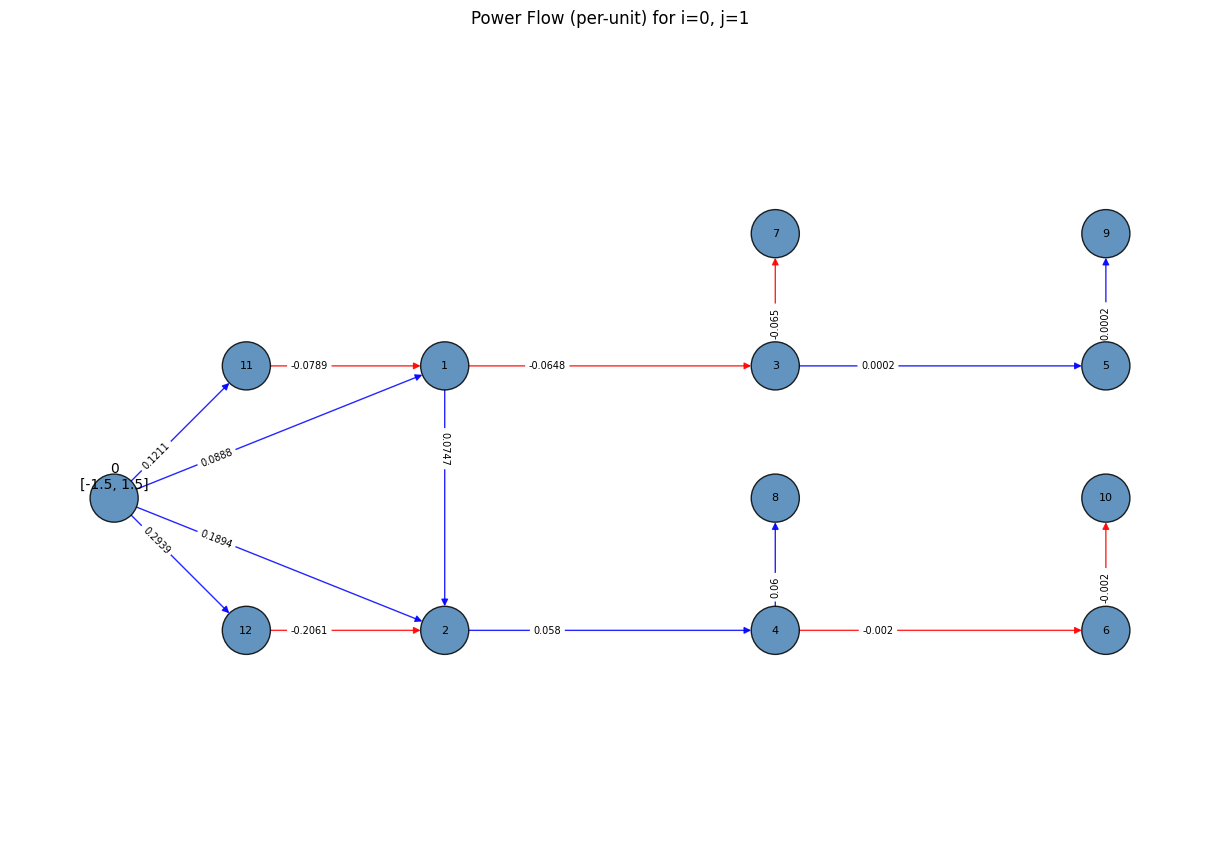

In [133]:
def plot_power_flow(m, i, j):
    pos = nx.get_node_attributes(G, 'pos')
    # Use node indices as labels
    labels = {}
    label_colors = [] # This is for node colors, will remove this later if needed or set to default
    for n in G.nodes():
        label_text = f"{n}"
        if n in m.parents:
            # Display parent bounds using the global P_min and P_max parameters
            label_text += f"\n[{P_min}, {P_max}]"
            # No specific color for label text here, use default
            label_colors.append('steelblue') # Default node color based on previous plots
        else:
            label_colors.append('steelblue') # Default node color
        labels[n] = label_text


    plt.figure(figsize=(12, 8))

    edge_colors = []
    edge_labels = {}

    for u, v in G.edges():
        try:
            # Correct the sign of the flow value for plotting
            flow_value = m.F[u, v, i, j].value
            if flow_value is not None:
                edge_labels[(u, v)] = f"{round(flow_value, 4)}"
                if flow_value > 0:
                    edge_colors.append('blue')  # Positive flow (now correctly represents flow from u to v)
                elif flow_value < 0:
                    edge_colors.append('red')  # Negative (reverse) flow (now correctly represents flow from v to u)
                else:
                    edge_colors.append('gray') # No flow
            else:
                edge_colors.append('gray') # No flow value
        except:
            edge_colors.append('gray') # Handle cases where edge might not be in m.F

    # Draw the network
    nx.draw(
        G, pos,
        with_labels=False, # Draw labels separately for color control
        node_size=1200,
        edge_color=edge_colors, # Use the calculated edge colors
        edgecolors="black", font_size=8,
        alpha=0.85,
        node_color = label_colors # Apply node colors
    )

    # Draw labels with different colors
    for n in G.nodes():
        x, y = pos[n]
        text = labels[n]
        if n in m.parents:
             plt.text(x, y + 0.1, text, fontsize=10, ha='center', va='bottom', color='black') # Color parent bounds black
        else:
             plt.text(x, y, text, fontsize=8, ha='center', va='center', color='black') # Default color for other labels


    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.3)

    plt.title(f"Power Flow (per-unit) for i={i}, j={j}")
    plt.axis("equal")
    plt.show()

# Example usage (assuming m, i=0, and j=0 are defined)
plot_power_flow(m, 0, 1)

In [134]:
def create_network():

    import pandapower as pp

# Crée le réseau
    net = pp.create_empty_network()

# Bases
    Pbase = 100  # MVA
    Vbase_high = 110  # kV
    Vbase_medium = 20  # kV
    Vbase_low = 0.4  # kV

# Buses
    b0 = pp.create_bus(net, vn_kv=Vbase_high, name="Bus grid", geodata=(0,10))
    b1 = pp.create_bus(net, vn_kv=Vbase_high, name="DSO 1", geodata=(5,12))
    b2 = pp.create_bus(net, vn_kv=Vbase_high, name="DSO 2", geodata=(5,8))
    b3 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus MV_1", geodata=(10,12))
    b4 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus MV_2", geodata=(10,8))
    b5 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus LV_1", geodata=(15,12))
    b6 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus LV_2", geodata=(15,8))
    b7 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus éolien", geodata=(10,14))
    b8 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus industriel", geodata=(10,10))
    b9 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus load", geodata=(15,14))
    b10 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus PV", geodata=(15,10))
    b11 = pp.create_bus(net, vn_kv=Vbase_high, name="TSO 1", geodata=(2,12))
    b12 = pp.create_bus(net, vn_kv=Vbase_high, name="TSO 2", geodata=(2,8))

# Lignes
    pp.create_line(net, b0, b1, length_km=12, std_type='149-AL1/24-ST1A 110.0', name="line1")
    pp.create_line(net, b1, b2, length_km=10, std_type='149-AL1/24-ST1A 110.0', name="line2")
    pp.create_line(net, b0, b2, length_km=10, std_type='149-AL1/24-ST1A 110.0', name="line3")
    pp.create_line(net, b3, b7, length_km=0.23, std_type='NA2XS2Y 1x185 RM/25 12/20 kV', name="line4")
    pp.create_line(net, b4, b8, length_km=0.3, std_type='NA2XS2Y 1x185 RM/25 12/20 kV', name="line5")
    pp.create_line(net, b5, b9, length_km=3, std_type='94-AL1/15-ST1A 0.4', name="line6")
    pp.create_line(net, b6, b10, length_km=0.45, std_type='94-AL1/15-ST1A 0.4', name="line7")
    pp.create_line(net, b0, b11, length_km=16, std_type='149-AL1/24-ST1A 110.0', name= 'line8')
    pp.create_line(net, b11, b1, length_km=24, std_type='149-AL1/24-ST1A 110.0', name= 'line9')
    pp.create_line(net, b0, b12, length_km=22, std_type='149-AL1/24-ST1A 110.0', name= 'line10')
    pp.create_line(net, b12, b2, length_km=16, std_type='149-AL1/24-ST1A 110.0', name= 'line11')

# Transformateurs
    pp.create_transformer(net, b1, b3, std_type="25 MVA 110/20 kV", name="TR_1")
    pp.create_transformer(net, b2, b4, std_type="25 MVA 110/20 kV", name="TR_2")
    pp.create_transformer(net, b3, b5, std_type="0.4 MVA 20/0.4 kV", name="TR_3")
    pp.create_transformer(net, b4, b6, std_type="0.4 MVA 20/0.4 kV", name="TR_4")

# Éléments de bus
    pp.create_ext_grid(net, bus=b0, vm_pu=1.00, name="Grid Connection")
    pp.create_load(net, bus=b9, p_mw=0.02, q_mvar=0.02, name="Residential Load")
    pp.create_gen(net, bus=b10, p_mw=0.2, vm_pu=1.00, name="PV", max_q_mvar=200, min_q_mvar=0, max_p_mw=300, min_p_mw=0, controllable=False)
    pp.create_gen(net, bus=b7, p_mw=6.5, vm_pu=1.0, name="Wind Turbine", controllable=False)
    pp.create_load(net, bus=b8, p_mw=6, q_mvar=1.8, name="Industry")
    pp.create_load(net, bus=b11, p_mw=20, q_mvar=9, name="Datacenter")
    pp.create_load(net, bus=b12, p_mw=50, q_mvar=24, name="Big industry")

# Donner accès à net
    return net

In [135]:
def create_digraph():
  net = create_network()

  import json
  import networkx as nx
  import matplotlib.pyplot as plt
# 1. Conversion du réseau Pandapower en DiGraph
# ================================
  G = nx.DiGraph()

# Créer les positions à partir de la colonne "geo"
  pos = {}
  for idx, row in net.bus.iterrows():
  # Extraire le champ 'geo' qui est une chaîne de caractères représentant un dictionnaire JSON
      geo_data = row['geo']

  # Convertir la chaîne JSON en un dictionnaire Python
      geo_dict = json.loads(geo_data)

  # Extraire la liste des coordonnées
      coordinates = geo_dict["coordinates"]

  # Ajouter les coordonnées dans le dictionnaire pos
      pos[idx] = tuple(coordinates)  # Assigner les coordonnées sous forme de tuple

# Ajouter les nœuds (avec le nom comme label) and voltage
  for idx, row in net.bus.iterrows():
      G.add_node(idx, label=row["name"], pos=pos[idx], vn_kv=row["vn_kv"])


# Ajouter les arêtes pour les lines
  for _, row in net.line.iterrows():
      G.add_edge(row["from_bus"], row["to_bus"], type="line", name=row["name"], length=row["length_km"], std_type=row["std_type"])

# Ajouter les arêtes pour les transformateurs
  for _, row in net.trafo.iterrows():
      G.add_edge(row["hv_bus"], row["lv_bus"], type="trafo", name=row["name"], std_type = None)

# Ajouter les générateurs et les charges comme attributs aux nœuds
  for _, row in net.gen.iterrows():
      G.nodes[row["bus"]]["type"] = "gen"
      G.nodes[row["bus"]]["gen_name"] = row["name"]
      G.nodes[row["bus"]]["gen_power"] = row["p_mw"]

  for _, row in net.load.iterrows():
      G.nodes[row["bus"]]["type"] = "load"
      G.nodes[row["bus"]]["load_name"] = row["name"]
      G.nodes[row["bus"]]["load_power"] = row["p_mw"]

  for _, row in net.ext_grid.iterrows():
      G.nodes[row["bus"]]["type"] = "ext_grid"
      G.nodes[row["bus"]]["grid_name"] = row["name"]

# 2. Ajout des puissances consommées et injectées aux nœuds
# ================================
  nx.set_node_attributes(G, 0.0, "P_load")
  nx.set_node_attributes(G, 0.0, "P_gen")

# Charges
  for _, row in net.load.iterrows():
      G.nodes[row["bus"]]["P_load"] += row["p_mw"]
      print(row)

# Générateurs
  for _, row in net.gen.iterrows():
      G.nodes[row["bus"]]["P_gen"] += row["p_mw"]

# Source externe
  for _, row in net.ext_grid.iterrows():
      G.nodes[row["bus"]]["P_gen"] += 0

# Calculate P_net
  for n in G.nodes:
      G.nodes[n]["P_net"] = G.nodes[n]["P_gen"] - G.nodes[n]["P_load"]

# Create subnetworks (NetworkX DiGraphs) from the main graph G
  network1_buses = [0, 1, 2, 11,12]
  network2_buses = [3, 7, 5, 9, 10]
  network3_buses = [4, 8, 6]

# Assign G1 to G and then add power attributes to nodes in G
  G = G.subgraph(network1_buses)

  for n in G.nodes:
      G.nodes[n]["P"] = G.nodes[n]["P_net"] # Assign P_net to 'P' attribute

# 3. Préparer les couleurs des nœuds en fonction de P_net
# ================================
  node_colors = []
  for n, data in G.nodes(data=True):
      if data["P_net"] > 0:
          node_colors.append("green")   # producteur
      elif data["P_net"] < 0:
          node_colors.append("red")     # consommateur
      else:
          node_colors.append("gray")    # neutre

# 4. Préparer les labels : Nom + P_net
# ================================
  labels = {n: f"{data['label']}\nP={round(data['P_net'],2)}MW"
            for n, data in G.nodes(data=True)}

# 5. Function to plot the network
# ================================
  def plot_network():
      pos = nx.get_node_attributes(G, 'pos')

      plt.figure(figsize=(12, 8))
      nx.draw(
          G, pos,
          with_labels=True, labels=labels,
          node_size=1200, node_color=node_colors,
          edgecolors="black", font_size=8,
          alpha=0.85
          )

  # Labels des arêtes (type ligne ou trafo)
      edge_labels = nx.get_edge_attributes(G, 'type')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

      plt.title("Réseau électrique avec puissances (P_net)")
      plt.axis("equal")
      plt.show()


  return G, plot_network()

name               Residential Load
bus                               9
p_mw                           0.02
q_mvar                         0.02
const_z_percent                 0.0
const_i_percent                 0.0
sn_mva                          NaN
scaling                         1.0
in_service                     True
type                            wye
Name: 0, dtype: object
name               Industry
bus                       8
p_mw                    6.0
q_mvar                  1.8
const_z_percent         0.0
const_i_percent         0.0
sn_mva                  NaN
scaling                 1.0
in_service             True
type                    wye
Name: 1, dtype: object
name               Datacenter
bus                        11
p_mw                     20.0
q_mvar                    9.0
const_z_percent           0.0
const_i_percent           0.0
sn_mva                    NaN
scaling                   1.0
in_service               True
type                      wye
Name: 2, dtype

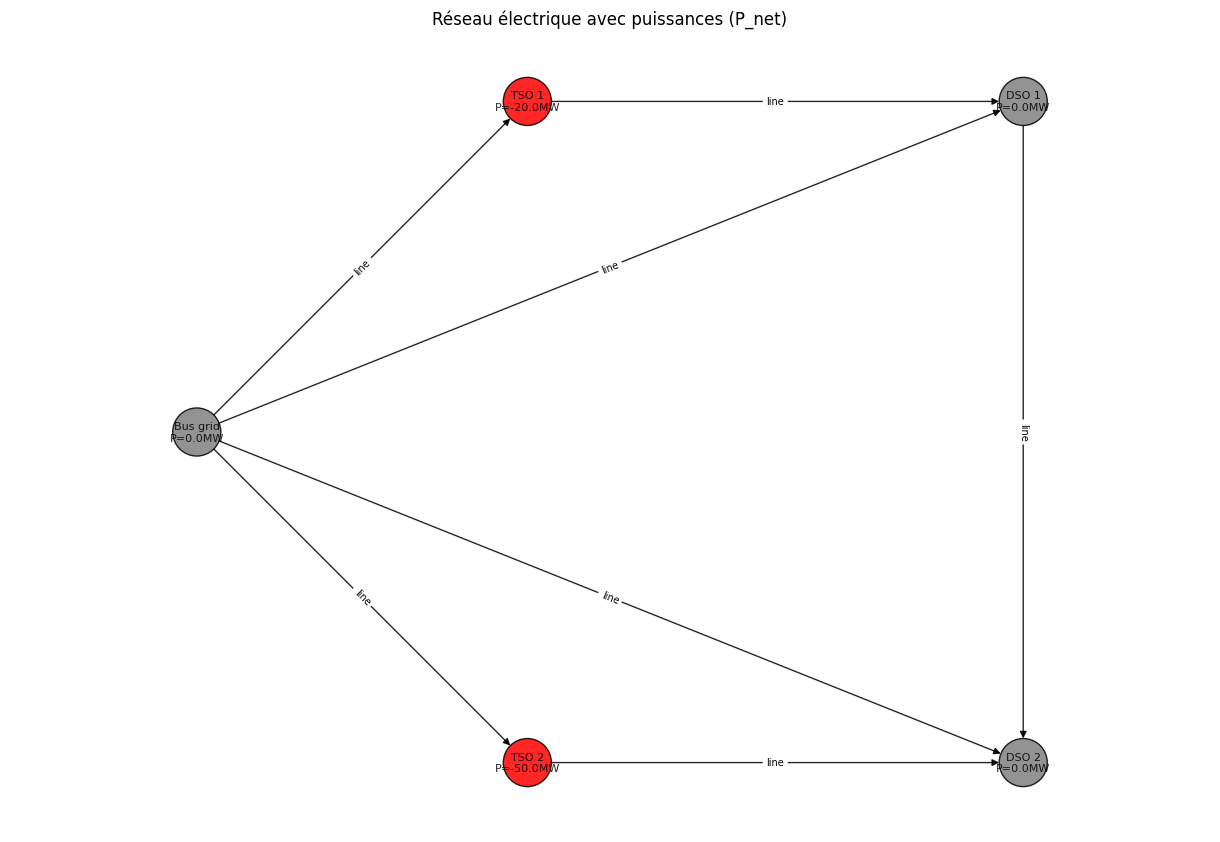

In [136]:
G, plot_func = create_digraph()

In [137]:
#Calculate the susceptance of each line in Siemens per km
strange = 1000
for u, v in G.edges():
    G[u][v]['b'] = length(u,v)* 200*10**-6 *strange
    print(G[u][v]['b'])

0.010770329614269008
0.010770329614269008
0.005656854249492381
0.005656854249492381
0.008
0.006
0.006


In [138]:
# Convert susceptance 'b' on edges to per-unit
for u, v in G.edges():
    # Assuming 'b' is in Siemens/km, convert to per-unit
    # b_pu = b_actual * (V_base^2 / S_base)
    # V_base is assumed to be v_base_high (110 kV)
    G[u][v]['b_pu'] = G[u][v].get('b', 0.0) * (get_base_node_voltage_kv(u)**2 / s_base)
    print(G[u][v]['b_pu'])

1.30320988332655
1.30320988332655
0.6844793641885781
0.6844793641885781
0.968
0.726
0.726


In [139]:
m = pyo.ConcreteModel()
# Define base values for the per-unit system
s_base = 100  # MVA
v_base_high = 110 # kV (From the create_network function)

m.Nodes = pyo.Set(initialize= [b for b in G.nodes])
m.Lines = pyo.Set(initialize= [l for l in G.edges])
m.i = pyo.Set(initialize=[0, 1]) # Initialize m.i with two generic elements
m.j = pyo.Set(initialize= [0, 1])
m.children = pyo.Set(initialize= [1, 2])
m.parents = pyo.Set(initialize = [0])

m.P = pyo.Param(m.Nodes, initialize = {n: - G.nodes[n].get('P') for n in G.nodes}, domain = pyo.Reals, mutable=True) # Make P mutable

m.info_DSO_param = pyo.Param(m.children, initialize = {n: info_DSO[n-1] for n in m.children}, domain = pyo.Reals) # Renamed parameter and adjusted index for list

m.I_min = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds(G.edges[i,j]["std_type"], get_base_node_voltage_kv(i))[0] for (i,j) in m.Lines}, domain = pyo.Reals)
m.I_max = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds(G.edges[i,j]["std_type"], get_base_node_voltage_kv(i))[1] for (i,j) in m.Lines}, domain = pyo.Reals)

print(m.I_min[(0,1)])
print(m.I_max[(0,1)])

# Variables principales
m.F = pyo.Var(m.Lines, m.i, m.j, domain=pyo.Reals)     # active power flow through lines
m.I = pyo.Var(m.Lines,  m.i, m.j, domain=pyo.Reals)  # current flowing through lines
m.theta = pyo.Var(m.Nodes,  m.i, m.j, domain=pyo.Reals)  # phase angle of the voltage
m.V = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)  # voltage magnitude at each node
m.E = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals) #net power injection/consumption
m.P_plus = pyo.Var(m.parents, m.i, m.j, domain=pyo.Reals) #power entering the operational graph
m.P_minus = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals) #power leaving the operational graph

m.P_C_set = pyo.Var(m.children, m.i, domain=pyo.Reals) #vertices of the power envelope at each child node

#m.P_C_min = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals)
#m.P_C_max = pyo.Var(m.children, m.i, m.j,  domain=pyo.Reals)

m.V_P = pyo.Param(m.j, initialize = {0: 0.9, 1: 1.1}, domain =pyo.NonNegativeReals)

m.O = pyo.Var(domain= pyo.NonNegativeReals)
m.tot = pyo.Var(domain= pyo.Reals)
m.aux = pyo.Var(m.children, domain=pyo.Reals)


for u in G.nodes():
  if G.nodes[u].get('P', 0.0) / s_base == 0:
    m.P[u] = 0
  else:
    G.nodes[u]['P_pu'] = G.nodes[u].get('P', 0.0) / s_base
    m.P[u] = - G.nodes[u]['P_pu']

"""# Convert P parameter to per-unit
for n in G.nodes:
    # Assuming P is in MW, convert to per-unit
    G.nodes[n]['P'] = G.nodes[n].get('P', 0.0) / s_base
    m.P[n] = G.nodes[n]['P']"""


# Convert susceptance 'b' on edges to per-unit
for u, v in G.edges():
    # Assuming 'b' is in Siemens/km, convert to per-unit
    # b_pu = b_actual * (V_base^2 / S_base)
    # V_base is assumed to be v_base_high (110 kV)
    G[u][v]['b_pu'] = G[u][v].get('b', 0.0) * (get_base_node_voltage_kv(u)**2 / s_base)

    print(G[u][v]['b_pu'])

-0.8954702675131095
0.8954702675131095
1.30320988332655
1.30320988332655
0.6844793641885781
0.6844793641885781
0.968
0.726
0.726


In [140]:
for n in G.nodes:
  print(m.P[n].value)
m.P[1].value


0
0
0
0.2
0.5


0

In [142]:
#Children nodes consumption
def worst_case_children(m, n, vert_pow, vert_volt):
  return m.P_C_set[n, vert_pow] == m.P_minus[n, vert_pow, vert_volt]
m.worst_case = pyo.Constraint(m.children, m.i, m.j, rule=worst_case_children)


# Auxiliary variable for the absolute value of E (already defined as per-unit)
m.z = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)

m.curt = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals)

def curtailment_def_rule(m,n, vert_pow, vert_volt):

  return m.curt[n, vert_pow, vert_volt] == m.P[n] - m.E[n, vert_pow, vert_volt]

m.curt_def = pyo.Constraint(m.Nodes, m.i, m.j, rule=curtailment_def_rule)
# Constraints to define the absolute value (already defined for per-unit E)
def abs_E_pos_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= m.curt[n, vert_pow, vert_volt]
m.abs_E_pos = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_pos_rule)

def abs_E_neg_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= -m.curt[n, vert_pow, vert_volt]
m.abs_E_neg = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_neg_rule)

def upper_bound_rule(m, vert_pow, vert_volt):
    # m.z is per-unit, m.O is per-unit
    return sum(m.z[n, vert_pow, vert_volt] for n in m.Nodes) <= m.O

m.upper_bound = pyo.Constraint(m.i, m.j, rule=upper_bound_rule)

# Current magnitude constraint (I_min, I_max are assumed per-unit)
def current_bounds_rule(m, i, j, vert_pow, vert_volt):
    # m.I is per-unit current
    return pyo.inequality(m.I_min[(i,j)], m.I[i,j, vert_pow, vert_volt], m.I_max[(i,j)])
m.CurrentBounds = pyo.Constraint(m.Lines, m.i, m.j, rule=current_bounds_rule)

def phase_constr_rule(m,n, vert_pow, vert_volt):
    return pyo.inequality(theta_min/10, m.theta[n, vert_pow, vert_volt], theta_max/10)

m.phaseConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=phase_constr_rule)

def dc_power_flow_rule(m, i, j, vert_pow, vert_volt):
    return m.F[i, j, vert_pow, vert_volt] == m.V_P[vert_volt]**2 *(G[i][j]['b_pu'] * (
        m.theta[i, vert_pow, vert_volt] - m.theta[j, vert_pow, vert_volt])
    )

m.DCFlow = pyo.Constraint(m.Lines, m.i, m.j, rule=dc_power_flow_rule)


def current_def_rule(m, n, i, j, vert_pow, vert_volt):
    # This constraint relates per-unit current, per-unit voltage, and per-unit power flow.
    # In per-unit, P_pu = V_pu * I_pu. This is correct.
    return m.I[i,j, vert_pow, vert_volt] * m.V_P[vert_volt] == m.F[i,j, vert_pow, vert_volt]

m.current_def = pyo.Constraint(m.Nodes, m.Lines, m.i, m.j, rule=current_def_rule)



def nodes_balance(m, n, vert_pow, vert_volt):
    inflow = sum(m.F[k, n, vert_pow, vert_volt] for k in G.predecessors(n) if (k, n) in m.Lines)
    outflow = sum(m.F[n, j, vert_pow, vert_volt] for j in G.successors(n) if (n, j) in m.Lines)
    if n in m.parents:
      return inflow - outflow  ==  m.E[n, vert_pow, vert_volt] - m.P_plus[n, vert_pow, vert_volt]

    if n in m.children:
      return inflow - outflow  ==  m.E[n, vert_pow, vert_volt] + m.P_minus[n, vert_pow, vert_volt]

    else:
      return inflow - outflow ==  m.E[n,vert_pow,vert_volt]

m.nodes_balance = pyo.Constraint(m.Nodes, m.i, m.j, rule=nodes_balance)


def parent_power_constraint_rule(m, parent, vert_pow, vert_volt):
    # m.P_plus is per-unit power entering the operational graph
    return pyo.inequality(0, m.P_plus[parent, vert_pow, vert_volt], P_max)

m.parent_power_constraint = pyo.Constraint(m.parents, m.i, m.j, rule=parent_power_constraint_rule)

def parent_power_constraint_rule2(m, parent, vert_pow, vert_volt):
    # m.P_plus is per-unit power entering the operational graph
    return pyo.inequality(P_min, m.P_minus[parent, vert_pow, vert_volt], P_max)

m.parent_power_constraint2 = pyo.Constraint(m.children, m.i, m.j, rule=parent_power_constraint_rule2)

#Constant voltage assumption
def voltage_constr_rule(m, n, vert_pow, vert_volt):
    return m.V[n, vert_pow, vert_volt] == m.V_P[vert_volt]

m.voltageConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=voltage_constr_rule)

def children_voltage_rule(m, children, vert_pow, vert_volt):
    return pyo.inequality(V_min, m.V[children, vert_pow, vert_volt], V_max)

m.children_voltage = pyo.Constraint(m.children, m.i, m.j, rule=children_voltage_rule)



def aux_constraint_rule(m, n):
  return m.aux[n] == m.P_C_set[n, 0] - m.P_C_set[n, 1]
m.aux_constraint = pyo.Constraint(m.children, rule=aux_constraint_rule)


def info_DSO_min_rule(m,n):
  return m.P_C_set[n,1] <= m.info_DSO_param[n]
m.info_DSO_min = pyo.Constraint(m.children, rule=info_DSO_min_rule)

def info_DSO_max_rule(m,n):
  return m.P_C_set[n,0] >= m.info_DSO_param[n]
m.info_DSO_max = pyo.Constraint(m.children, rule=info_DSO_max_rule)

def tot_rule(m):
  return m.tot == sum(m.aux[n] for n in m.children)
m.tot_constraint = pyo.Constraint(rule=tot_rule)

"""# Auxiliary variables for the L1 norm of P_C_set
m.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)

# Constraints to linearize the L1 norm of P_C_set
def abs_P_C_set_pos_rule(m, n):
    return m.abs_P_C_set[n] >= m.aux[n]
m.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)

def abs_P_C_set_neg_rule(m, n):
    return m.abs_P_C_set[n] >= -m.aux[n]
m.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)"""

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


'# Auxiliary variables for the L1 norm of P_C_set\nm.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)\n\n# Constraints to linearize the L1 norm of P_C_set\ndef abs_P_C_set_pos_rule(m, n):\n    return m.abs_P_C_set[n] >= m.aux[n]\nm.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)\n\ndef abs_P_C_set_neg_rule(m, n):\n    return m.abs_P_C_set[n] >= -m.aux[n]\nm.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)'

In [162]:
A = [0.5,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,2,2.05,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.1,3.2]
#A = range(-3, 26)

enveloppe_taille = []
curtail = []

for alpha in A:
  print(alpha)
  def objective_rule(m):
    return  m.tot - alpha*m.O
  m.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)
  params = {
    "WLSACCESSID": 'efa10779-150a-495c-ab62-6a20ff44c598',
    "WLSSECRET": 'fa980d94-a6fd-4d7b-aa68-b0e19ddd2e84',
    "LICENSEID": 2651433,
           }
  env = gp.Env(params=params)
  solver = pyo.SolverFactory('gurobi', env= env)
  results = solver.solve(m, tee=True)

  # Check the termination condition before accessing results
  if results.solver.termination_condition == pyo.TerminationCondition.optimal:
      curtail.append(m.O.value)
      enveloppe_taille.append(m.tot.value)
  else:
      # Append None or some indicator for non-optimal results
      curtail.append(None)
      enveloppe_taille.append(None)

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


0.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpr4cowccr.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x1c93533c
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7618465e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpp121s0u9.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x512b6ede
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.1
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpt7m45kuo.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0xfc04bbd9
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.2
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpqfy6l7h3.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x66dc92c5
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.3
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp1zswhwnd.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0xcd29968f
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmphy92zl9w.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0xec3c0998
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00   3

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpx9f3qu5y.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x852dd035
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00   3

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.6
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpp0mo8eq2.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x6039aa14
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.7
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp88i51k8p.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x783793e6
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp51a5dao6.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0xdd1c7cec
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00   3.

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.9
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp1khwy_6e.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x00674208
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmph5wxpibg.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0xcb7ff9f4
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00   3

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmps11s26ke.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x8bcfbe3c
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.05
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpptf6vhk7.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x7385afc6
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.1
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpe1ux5pnf.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0xde3cc6db
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.01s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp7tdnrh1c.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0xf8bff583
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00   3.

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.3
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpei8n_p_c.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x1fc813fc
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.4
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpyug2gvos.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x5e385c57
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpscedkkbd.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0xf9da414b
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00   3.

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.6
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpc_z4cono.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x551ef68e
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.7
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpwl18lbr8.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x2d419484
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.8
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpwx9gmd1t.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0xb4eaccd0
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpuq6af85r.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0x35a7acfb
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00   3.

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


3
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp77f1wpic.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0xad9733f5
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


3.1
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpbx54jxvi.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0xdb610309
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


3.2
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpq7l3tjxl.pyomo.lp
Reading time = 0.00 seconds
x1: 423 rows, 176 columns, 781 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 423 rows, 176 columns and 781 nonzeros
Model fingerprint: 0xb867ee51
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 352 rows and 100 columns
Presolve time: 0.00s
Presolved: 71 rows, 76 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5236930e+00 

In [163]:
print(enveloppe_taille)
print(curtail)

[6.0, 6.0, 5.900000000000006, 5.900000000000006, 5.900000000000006, 5.900000000000006, 5.900000000000006, 5.900000000000006, 5.900000000000006, 5.900000000000006, 5.900000000000006, 5.900000000000006, 4.4328800213666835, 1.4999999999999947, 1.4999999999999947, 1.4999999999999947, 1.4999999999999947, 1.4999999999999947, 1.4999999999999947, 1.4999999999999947, 1.4999999999999947, 1.4999999999999947, 1.4999999999999947, 1.4999999999999947, 1.5000000000000173, 1.5000000000000173]
[2.299999999999999, 2.3, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 1.466440010683345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


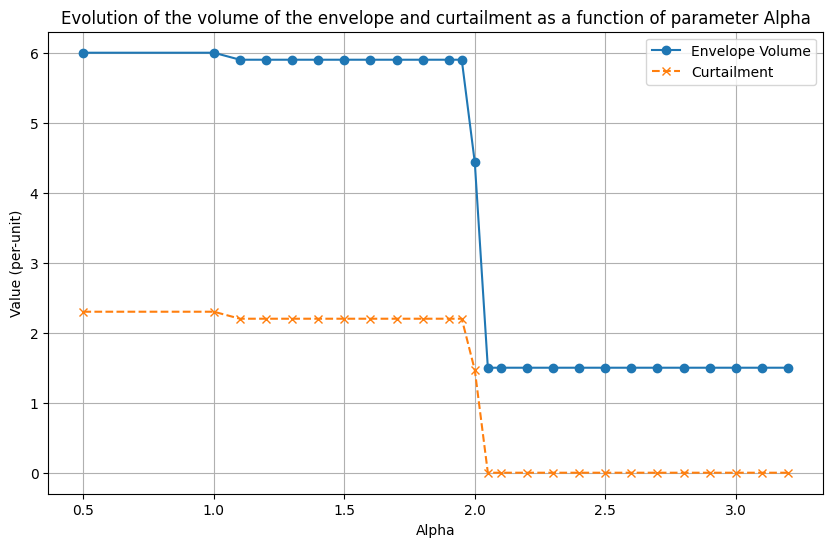

In [165]:
import matplotlib.pyplot as plt
import numpy as np

# Convert A to a numpy array for easier plotting
alpha_values = np.array(A)

# Convert lists to numpy arrays, replacing None with NaN for plotting
enveloppe_taille_np = np.array(enveloppe_taille, dtype=float)
curtail_np = np.array(curtail, dtype=float)


plt.figure(figsize=(10, 6))

# Plot enveloppe_taille vs alpha
plt.plot(alpha_values, enveloppe_taille_np, marker='o', linestyle='-', label='Envelope Volume')

# Plot curtail vs alpha
plt.plot(alpha_values, curtail_np, marker='x', linestyle='--', label='Curtailment')

# Set x-axis to a logarithmic scale
#plt.xscale('log')

plt.xlabel('Alpha')
plt.ylabel('Value (per-unit)')
plt.title('Evolution of the volume of the envelope and curtailment as a function of parameter Alpha')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
print(m.E[0,0,0].value)
print(m.E[0,0,1].value)

print(m.E[11,0,0].value)
print(m.E[11,0,1].value)

print(m.E[12,0,0].value)
print(m.E[12,0,1].value)

0.0
0.0
0.2
0.2
0.5
0.5


In [42]:
print(m.F[0,11,0,0].value)
print(m.F[0,11,0,1].value)

0.1673502687026484
0.16735026870263192


In [78]:
print(m.P_C_set[1,0].value)
print(m.P_C_set[1,1].value)

print(m.P_C_set[2,0].value)
print(m.P_C_set[2,1].value)

-0.0648
-0.7972793616382904
0.8648000000000142
-1.4027206383617208


In [44]:
print(m.theta[0,0,0].value)
print(m.theta[0,0,1].value)

print(m.theta[11,0,0].value)
print(m.theta[11,0,1].value)

-179.24377539400172
-179.49376699929044
-179.54561834327484
-179.6958271554154


In [166]:

m.O.value


0.0

In [46]:
m.aux[1].value

0.7324793616382904

In [54]:
m.P_C_set[1,0].value

-0.0648

In [53]:
m.P_C_set[1,1].value

-0.7972793616382904

In [52]:
m.aux[2].value

2.2675206383617352

In [51]:
m.P[0].value

0

In [50]:
m.P_plus[0,0,1].value

1.5

In [49]:
m.P_minus[1,0,1].value

-0.0648

In [48]:
m.P_C_set[2,0].value

0.8648000000000142

In [47]:
m.P_C_set[1,1].value

-0.7972793616382904

In [55]:
for (u,v) in m.Lines:
  print((u,v))

(0, 1)
(0, 2)
(0, 11)
(0, 12)
(1, 2)
(11, 1)
(12, 2)


In [ ]:
# Corrected loop structure to iterate over m.Lines
for (u, v) in m.Lines:
  for vert_pow in m.i:
    for vert_volt in m.j:
      print(f"Flow on line ({u}, {v}) for i={vert_pow}, j={vert_volt}: {m.F[u, v, vert_pow, vert_volt].value}")

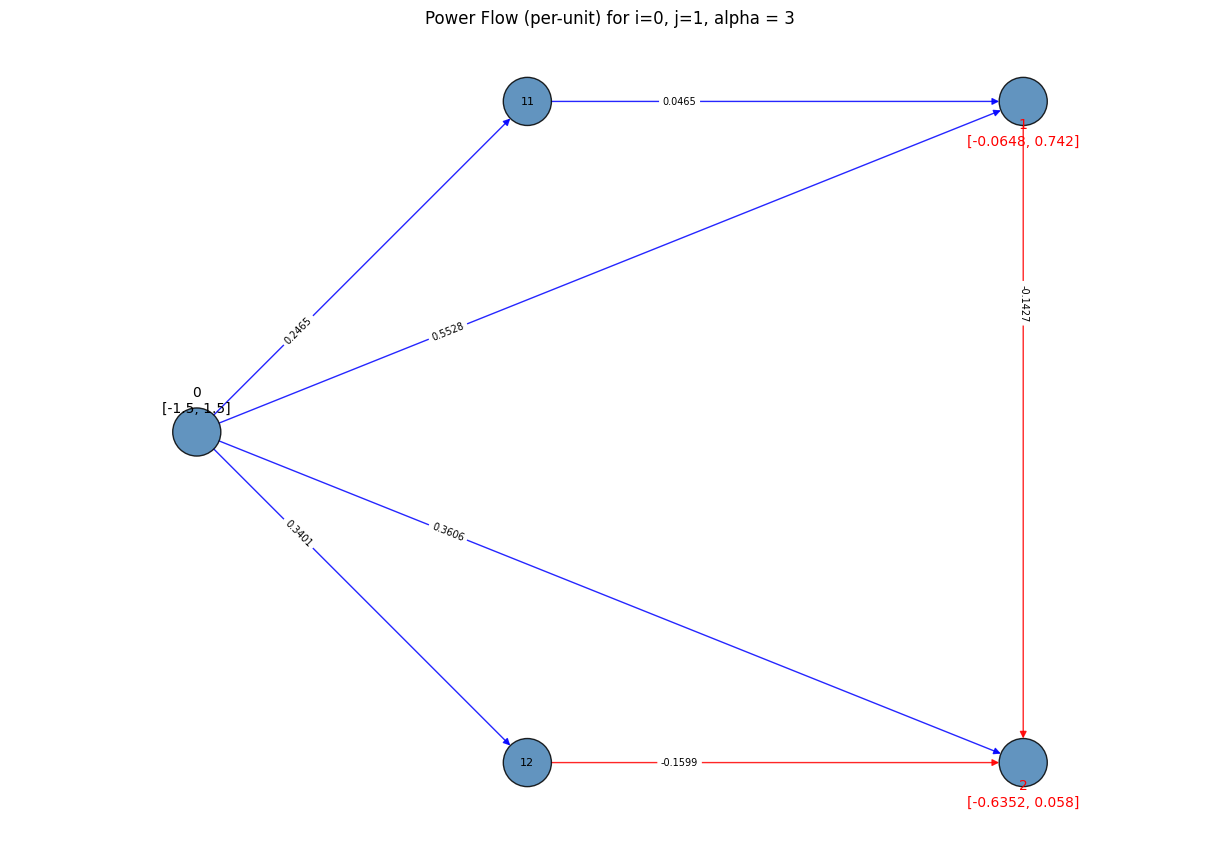

In [169]:
def plot_power_flow(m, i, j):
    pos = nx.get_node_attributes(G, 'pos')
    # Use node indices as labels
    labels = {}
    label_colors = [] # This is for node colors, will remove this later if needed or set to default
    for n in G.nodes():
        label_text = f"{n}"
        if n in m.parents:
            # Display parent bounds using the global P_min and P_max parameters
            label_text += f"\n[{P_min}, {P_max}]"
            # No specific color for label text here, use default
            label_colors.append('steelblue') # Default node color based on previous plots
        elif n in m.children:
            # Display children interval with smaller value first
            p_c_values = [m.P_C_set[n, 0].value, m.P_C_set[n, 1].value]
            label_text += f"\n[{round(min(p_c_values), 4)}, {round(max(p_c_values), 4)}]"
            # We will try to color this text red when drawing labels
            label_colors.append('steelblue') # Default node color
        else:
            label_colors.append('steelblue') # Default node color
        labels[n] = label_text


    plt.figure(figsize=(12, 8))

    edge_colors = []
    edge_labels = {}

    for u, v in G.edges():
        try:
            # Correct the sign of the flow value for plotting
            flow_value = m.F[u, v, i, j].value
            if flow_value is not None:
                edge_labels[(u, v)] = f"{round(flow_value, 4)}"
                if flow_value > 0:
                    edge_colors.append('blue')  # Positive flow (now correctly represents flow from u to v)
                elif flow_value < 0:
                    edge_colors.append('red')  # Negative (reverse) flow (now correctly represents flow from v to u)
                else:
                    edge_colors.append('gray') # No flow
            else:
                edge_colors.append('gray') # No flow value
        except:
            edge_colors.append('gray') # Handle cases where edge might not be in m.F

    # Draw the network
    nx.draw(
        G, pos,
        with_labels=False, # Draw labels separately for color control
        node_size=1200,
        edge_color=edge_colors, # Use the calculated edge colors
        edgecolors="black", font_size=8,
        alpha=0.85,
        node_color = label_colors # Apply node colors
    )

    # Draw labels with different colors
    for n in G.nodes():
        x, y = pos[n]
        text = labels[n]
        if n in m.children:
            plt.text(x, y - 0.1, text, fontsize=10, ha='center', va='top', color='red') # Color children interval red
        elif n in m.parents:
             plt.text(x, y + 0.1, text, fontsize=10, ha='center', va='bottom', color='black') # Color parent bounds black
        else:
             plt.text(x, y, text, fontsize=8, ha='center', va='center', color='black') # Default color for other labels


    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.3)

    plt.title(f"Power Flow (per-unit) for i={i}, j={j}, alpha = 3")
    plt.axis("equal")
    plt.show()

# Example usage (assuming m, i=0, and j=0 are defined)
plot_power_flow(m, 0, 1)

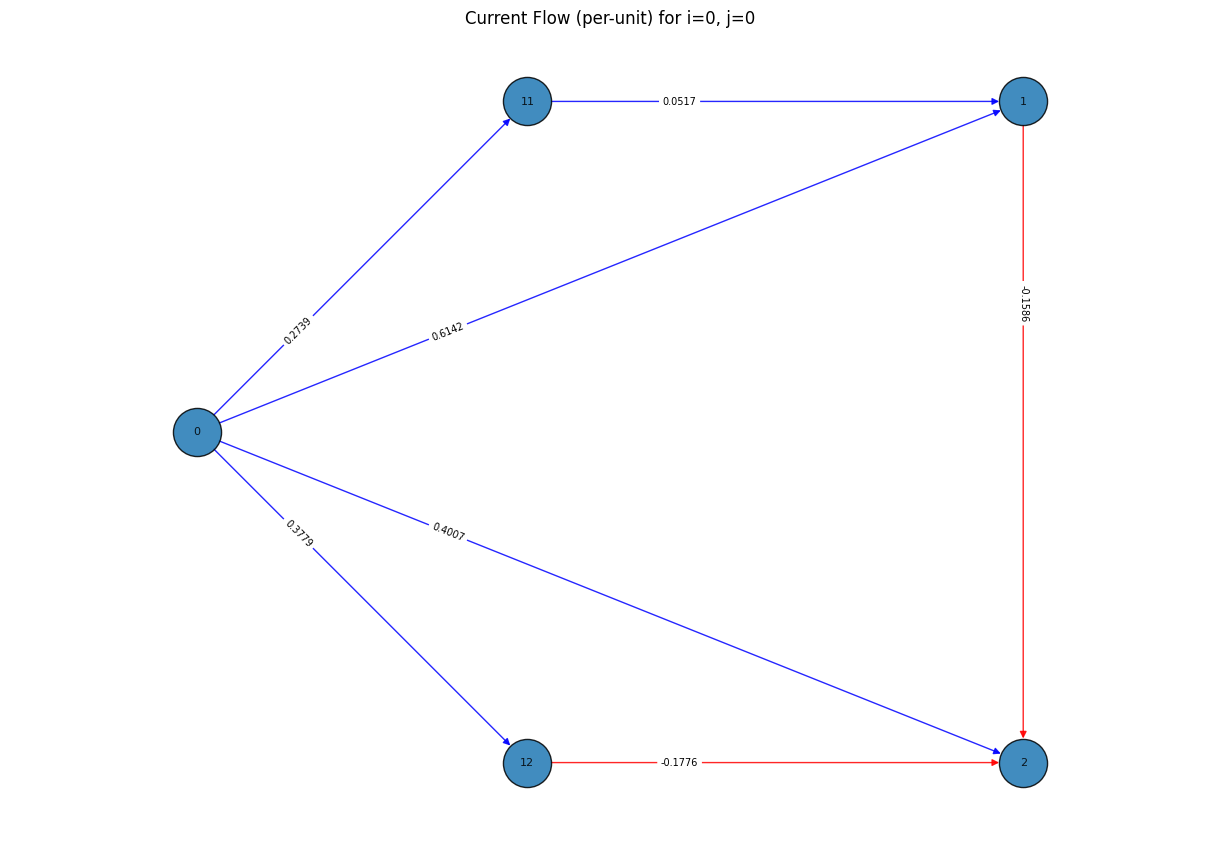

In [167]:
def plot_current_flow(m, i, j):
    pos = nx.get_node_attributes(G, 'pos')
    # Use node indices as labels
    labels = {n: n for n in G.nodes()}

    plt.figure(figsize=(12, 8))

    edge_colors = []
    edge_labels = {}

    for u, v in G.edges():
        try:
            # Get the current value from the model
            current_value = m.I[u, v, i, j].value
            if current_value is not None:
                edge_labels[(u, v)] = f"{round(current_value, 4)}"
                if current_value > 0:
                    edge_colors.append('blue')  # Positive current flow
                elif current_value < 0:
                    edge_colors.append('red')  # Negative current flow
                else:
                    edge_colors.append('gray') # No current flow
            else:
                edge_colors.append('gray') # No current value
        except:
            edge_colors.append('gray') # Handle cases where edge might not be in m.I

    nx.draw(
        G, pos,
        with_labels=True, labels=labels, # Set with_labels to True and pass node indices as labels
        node_size=1200,
        edge_color=edge_colors, # Use the calculated edge colors
        edgecolors="black", font_size=8,
        alpha=0.85
    )

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.3)

    plt.title(f"Current Flow (per-unit) for i={i}, j={j}")
    plt.axis("equal")
    plt.show()

# Example usage (assuming m, i=0, and j=0 are defined)
plot_current_flow(m, 0, 0)